In [2]:
%matplotlib inline

from PIL import Image, ImageDraw
import matplotlib.pyplot as plt
import numpy as np
from scipy.ndimage.filters import laplace
from skimage import feature

plt.rcParams['figure.figsize'] = (16, 16)

In [3]:
# https://gist.github.com/luispedro/3437255
# Copyright: Luis Pedro Coelho <luis@luispedro.org>, 2012
# License: MIT
import numpy as np

def read_roi(fileobj):
    '''
    points = read_roi(fileobj)

    Read ImageJ's ROI format
    '''
# This is based on:
# http://rsbweb.nih.gov/ij/developer/source/ij/io/RoiDecoder.java.html
# http://rsbweb.nih.gov/ij/developer/source/ij/io/RoiEncoder.java.html


    SPLINE_FIT = 1
    DOUBLE_HEADED = 2
    OUTLINE = 4
    OVERLAY_LABELS = 8
    OVERLAY_NAMES = 16
    OVERLAY_BACKGROUNDS = 32
    OVERLAY_BOLD = 64
    SUB_PIXEL_RESOLUTION = 128
    DRAW_OFFSET = 256


    pos = [4]
    def get8():
        pos[0] += 1
        s = fileobj.read(1)
        if not s:
            raise IOError('readroi: Unexpected EOF')
        return ord(s)

    def get16():
        b0 = get8()
        b1 = get8()
        return (b0 << 8) | b1

    def get32():
        s0 = get16()
        s1 = get16()
        return (s0 << 16) | s1

    def getfloat():
        v = np.int32(get32())
        return v.view(np.float32)

    magic = fileobj.read(4)
    if magic != 'Iout':
        raise IOError('Magic number not found')
    version = get16()

    # It seems that the roi type field occupies 2 Bytes, but only one is used
    roi_type = get8()
    # Discard second Byte:
    get8()

    if not (0 <= roi_type < 11):
        raise ValueError('roireader: ROI type %s not supported' % roi_type)

    if roi_type != 7:
        raise ValueError('roireader: ROI type %s not supported (!= 7)' % roi_type)

    top = get16()
    left = get16()
    bottom = get16()
    right = get16()
    n_coordinates = get16()

    x1 = getfloat() 
    y1 = getfloat() 
    x2 = getfloat() 
    y2 = getfloat()
    stroke_width = get16()
    shape_roi_size = get32()
    stroke_color = get32()
    fill_color = get32()
    subtype = get16()
    if subtype != 0:
        raise ValueError('roireader: ROI subtype %s not supported (!= 0)' % subtype)
    options = get16()
    arrow_style = get8()
    arrow_head_size = get8()
    rect_arc_size = get16()
    position = get32()
    header2offset = get32()

    if options & SUB_PIXEL_RESOLUTION:
        getc = getfloat
        points = np.empty((n_coordinates, 2), dtype=np.float32)
    else:
        getc = get16
        points = np.empty((n_coordinates, 2), dtype=np.int16)
    points[:,1] = [getc() for i in xrange(n_coordinates)]
    points[:,0] = [getc() for i in xrange(n_coordinates)]
    points[:,1] += left
    points[:,0] += top
    points -= 1
    return points

def read_roi_zip(fname):
    import zipfile
    with zipfile.ZipFile(fname) as zf:
        return [read_roi(zf.open(n))
                    for n in zf.namelist()]

In [4]:
# tif -> (time,w,h)
def load_stack(path):
    im = Image.open(path)
    stk = []
    while True:
        stk.append(np.array(im))
        try:
            im.seek(len(stk))
        except EOFError:
            break
    return np.array(stk, dtype='float32')

# roi zip -> (index,w,h)
def load_rois(path, width, height, fill=1, xdisp=0, ydisp=0):
    rois = read_roi_zip(open(path))
    ret = []
    for i,roi in enumerate(rois):
        poly = []
        for x in roi:
            poly.append((x[1]+xdisp,x[0]+ydisp))
        img = Image.new('L', (width, height), 0)
        ImageDraw.Draw(img).polygon(poly, outline=1, fill=fill)
        ret.append(np.array(img))
    return np.array(ret,dtype='float32')

In [5]:
# generate filenames
files = []
for i in range(1,4):
    for j in range(1,5):
        prefix = 'data/AMG%d_exp%d'%(i,j)
        files.append( (prefix+'.tif', prefix+'.zip') )

In [6]:
# load data
data = []
for i,(s,r) in enumerate(files):
    if i==8: # lolwtf
        data.append((load_stack(s), load_rois(r, 512, 512, xdisp=9, ydisp=-1)))
    else:
        data.append((load_stack(s), load_rois(r, 512, 512)))

In [7]:
# visualize one set
stk,rois = data[8]

M = stk.max(axis=0)
M = np.clip( (M-900)/500, 0, 1 )
M**=0.5

R = rois.max(axis=0)

K = np.zeros((512,512,3))
K[:,:,0] = K[:,:,1] = K[:,:,2] = M*0.4
K[:,:,2] = np.maximum(M,R)

plt.imshow(K)

In [8]:
# load all 2*r by 2*r tiles centered on neuron centroids
def NormalizeTile(tile):
    return (tile - tile.mean()) / tile.std()

w,h = [], []
tiles = []
Ztiles = []
r = 15

for stk, rois in data:
    M = stk.max(axis=0)
    for roi in rois:
        x,y = np.where(roi!=0)
        x,y = int(x.mean()), int(y.mean()) # compute centroid of roi
        if x-r>=0 and y-r>=0 and x+r<512 and y+r<512:
            tiles.append(M[x-r:x+r, y-r:y+r]) # grab tile
            Ztiles.append(NormalizeTile(M[x-r:x+r, y-r:y+r])) # grab z-scored tile
            
tiles = np.array(tiles)
Ztiles = np.array(Ztiles)

In [9]:
# render tiled image
Q = np.zeros((2*r*10, 2*r*10))
for i in range(10):
    for j in range(10):
        Q[2*r*i:2*r*(i+1),2*r*j:2*r*(j+1)] = Ztiles[10*i + j]

plt.imshow(Q,cmap='gray')

In [10]:
from sklearn.decomposition import PCA

In [11]:
# flatten 30x30 images to 900x1 vectors
Zvecs = Ztiles.copy()
Zvecs = Zvecs.reshape((Zvecs.shape[0], Zvecs.shape[1]*Zvecs.shape[2]))

In [12]:
# run pca
pca = PCA(n_components=10)
pca.fit(Zvecs)

PCA(copy=True, n_components=10, whiten=False)

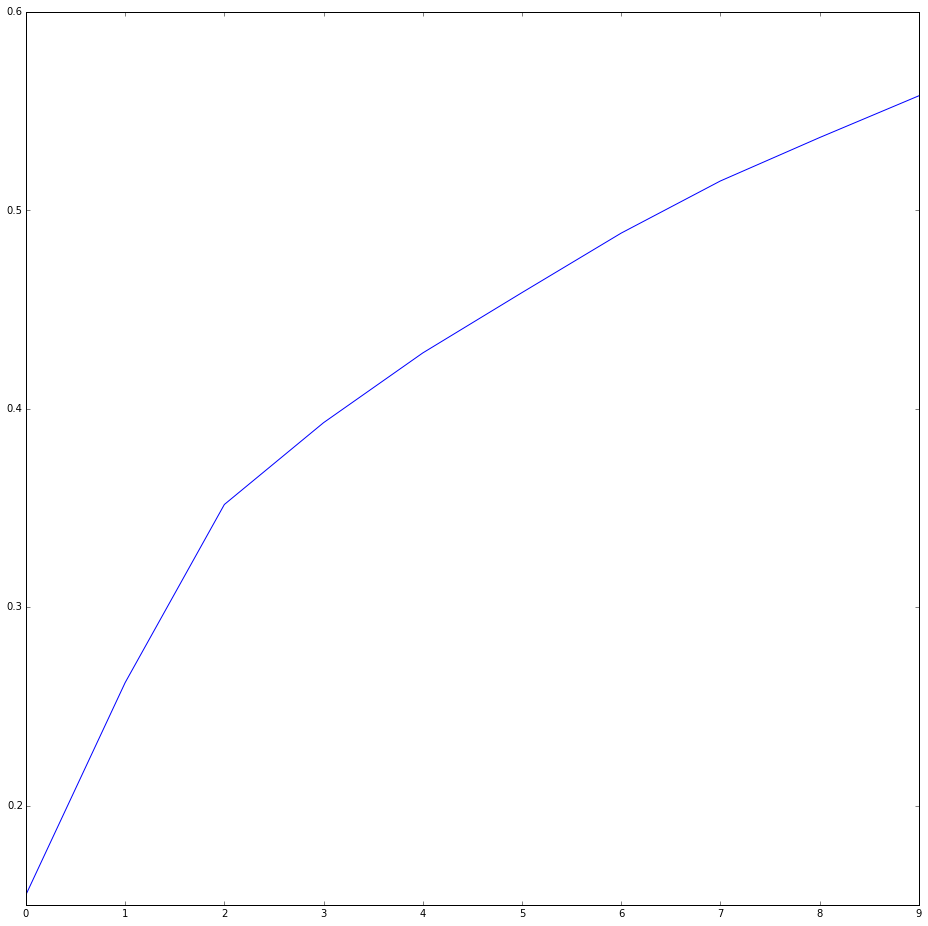

In [13]:
# render 1st principal component
# plt.imshow( pca.components_[0].reshape(30,30), cmap='gray')

# explained variance curve
plt.plot(np.cumsum(pca.explained_variance_ratio_))

In [14]:
# compute 2d cross-correlation with principal components as filters
from scipy.signal import correlate2d

filt = [pc.reshape(30,30) for pc in pca.components_]
Ci = [correlate2d(M, f, mode='same') for f in filt]

In [15]:
Q = np.zeros((512,512,3))

def sc(K):
    return (K-K.min())/(K.max()-K.min())

Q[:,:,0] = sc(Ci[3])
Q[:,:,1] = sc(Ci[4])
Q[:,:,2] = sc(Ci[5])
plt.imshow(Q)

plt.imshow(rois.any(axis=0), alpha=0.2)

In [16]:
Zt = pca.transform(Zvecs)

/Users/cyrilzhang/anaconda/lib/python2.7/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


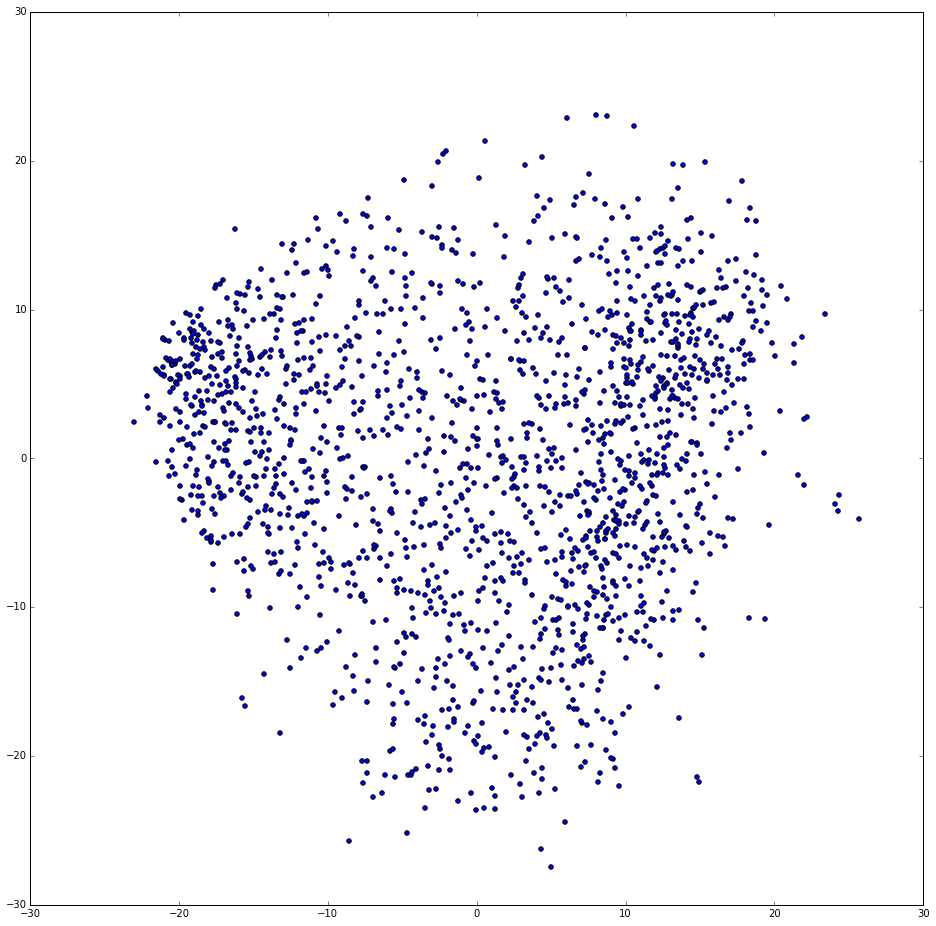

In [17]:
plt.scatter(Zt[:,0], Zt[:,1])